In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import re
import numpy as np
import pandas as pd

import SequenceDataORM_updt as sqd
import circularspacingtests as cst

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///NS001_evolved_mutations_copy8.db', echo=False) # our database connection
session = sessionmaker(bind=engine)() # the session object is how we make queries through sqlalchemy

# Grouping snps that should have been grouped

While doing earlier runs of this analysis, I found many clusters of mutations that should have been classified as a single mutational event. They occurred in only one well and on the same set of reads. This meant the cluster finding strategy I took from "Detecting Clusters of Mutations" by Zhou et al. was finding not only clusters due to natural selection but multiple mutations that should have been one mutation event.

In [3]:
snp_mutations = [mut for mut in session.query(sqd.SNP_Mutation).order_by(sqd.SNP_Mutation.chr_position)]

In [4]:
def snp_covs(snp_mut):
    smpls = snp_mut.samples
    new_covs = [(session.query(sqd.SNP_Evidence)
                        .filter(sqd.SNP_Evidence.sample == smpl)
                        .filter(sqd.SNP_Evidence.chr_position == snp_mut.chr_position)
                        .filter(sqd.SNP_Evidence.ref_base == snp_mut.ref_base)
                        .filter(sqd.SNP_Evidence.new_base == snp_mut.new_base)
                        .first()).new_cov for smpl in smpls]
    return new_covs

def is_close_cov(cov1, cov2):
    x1, y1 = [int(word) for word in cov1.split('/')]
    x2, y2 = [int(word) for word in cov2.split('/')]
    return ((x1 == x2) and (np.abs(y1-y2) <= 1)) or ((np.abs(x1 - x2) <= 1) and (y1 == y2))

def merge_snps(sorted_snp_list):
    merged_list = [sorted_snp_list[0]]
    curr_samples = merged_list[0].samples
    curr_position = merged_list[0].chr_position
    curr_covs = snp_covs(merged_list[0])
    for snp in sorted_snp_list[1:]:
        if (snp.chr_position <= curr_position + 100 and 
            set(snp.samples) == set(curr_samples) and
            np.all([is_close_cov(cov, curr_cov) for cov, curr_cov in zip(snp_covs(snp), curr_covs)])):
                pass
        else:
            merged_list.append(snp)
            curr_samples = snp.samples
            curr_position = snp.chr_position
            curr_covs = snp_covs(snp)
    return merged_list

In [5]:
len(snp_mutations)

937

In [6]:
merged_snps = merge_snps(snp_mutations)

In [7]:
len(merged_snps)

909

# Finding unusually dense clusters of mutations

In [8]:
snp_positions = np.sort(np.array([snp.chr_position for snp in merged_snps]))
N_bp = 4641652
p_clusters = cst.p_clusters(snp_positions, N_bp)

We need to cutoff p_clusters for clusters above a certain size. Otherwise we're more looking at the odds of the smaller cluster on the complementary section of the genome. The obvious cutoff is 915/2 but a more realistic cutoff is probably something like 10 (or generously 100).

In [9]:
p_clusters = p_clusters[:100,:]

In [10]:
most_l_mut_clusts = np.argmin(p_clusters, axis=0)

In [31]:
p_clusters.shape

(100, 909)

(array([785.,  14.,   7.,   4.,   5.,   3.,   4.,   3.,   2.,   2.,   3.,
          3.,   1.,   1.,   0.,   1.,   2.,   0.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.,
          2.,   2.,   2.,   2.,   1.,   2.,   2.,   1.,   0.,   0.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,
          0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,
          2.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.75, 25.74,
        26.73, 27.72, 28.71, 29.7 , 30.69, 31.68, 32.67, 33.66, 34.65,
        35.64, 36.63, 37.62, 38.61

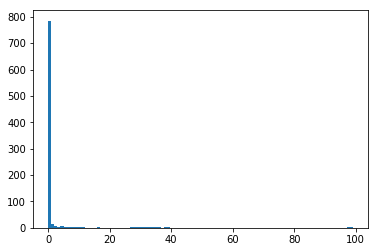

In [11]:
plt.hist(most_l_mut_clusts, bins=100)

In [12]:
most_l_mut_clusts

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,
        0,  0,  0,  0,  0,  0,  1,  5,  0,  0,  0,  0,  1,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        2,  3,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [13]:
np.unravel_index(np.argmin(p_clusters), p_clusters.shape)

(11, 386)

In [14]:
snp_positions[386]

1762620

In [15]:
merged_snps[386]

<SNP_Mutation(chr_position=1762620, ref_base=T, new_base=C, gene=sufB)>

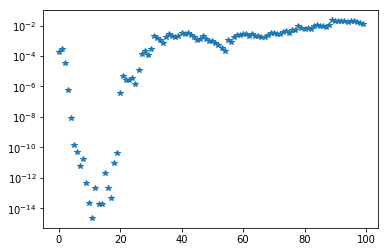

In [16]:
plt.semilogy(p_clusters[:,386], '*')

In [17]:
np.argmin(p_clusters[:,375])

6

In [18]:
merged_snps[375]

<SNP_Mutation(chr_position=1760934, ref_base=G, new_base=A, gene=sufD)>

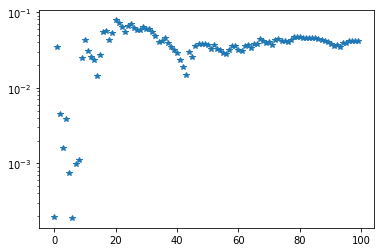

In [19]:
plt.semilogy(p_clusters[:,375], '*')

In [20]:
ml_cluster_ps = np.sort(np.min(p_clusters, axis=0))[:40]
print(ml_cluster_ps)

[2.36843546e-15 3.87652530e-14 4.23050045e-13 7.67725346e-12
 1.42566038e-11 3.77741290e-11 7.97864117e-11 4.30237712e-10
 4.79750495e-10 5.06107908e-10 9.78125367e-10 1.54245528e-09
 2.67559470e-09 4.06728284e-09 6.62838110e-09 1.18206708e-08
 1.30203638e-08 1.59494408e-08 1.82191341e-08 2.47920368e-08
 2.60193424e-08 2.88872105e-08 3.24076888e-08 3.79575665e-08
 4.05259763e-08 4.24289621e-08 7.36350084e-08 1.03255786e-07
 1.12805291e-07 1.36589537e-07 1.67402685e-07 1.72290965e-07
 1.76038153e-07 1.83219152e-07 1.90709585e-07 3.05354700e-07
 4.18108411e-07 6.65909983e-07 9.22414325e-07 3.16562942e-06]


In [21]:
for i in range(40):
    print(np.where(p_clusters == ml_cluster_ps[i]))

(array([11], dtype=int64), array([386], dtype=int64))
(array([10], dtype=int64), array([385], dtype=int64))
(array([9], dtype=int64), array([384], dtype=int64))
(array([6], dtype=int64), array([845], dtype=int64))
(array([8], dtype=int64), array([383], dtype=int64))
(array([7], dtype=int64), array([846], dtype=int64))
(array([2], dtype=int64), array([673], dtype=int64))
(array([13], dtype=int64), array([382], dtype=int64))
(array([5], dtype=int64), array([844], dtype=int64))
(array([18], dtype=int64), array([387], dtype=int64))
(array([21], dtype=int64), array([390], dtype=int64))
(array([20], dtype=int64), array([389], dtype=int64))
(array([19], dtype=int64), array([388], dtype=int64))
(array([12], dtype=int64), array([381], dtype=int64))
(array([23], dtype=int64), array([392], dtype=int64))
(array([22], dtype=int64), array([391], dtype=int64))
(array([4], dtype=int64), array([843], dtype=int64))
(array([32], dtype=int64), array([401], dtype=int64))
(array([28], dtype=int64), array([3

In [22]:
merged_snps[845]

<SNP_Mutation(chr_position=4296284, ref_base=C, new_base=T, gene=gltP/yjcO)>

In [23]:
merged_snps[673]

<SNP_Mutation(chr_position=3248828, ref_base=T, new_base=A, gene=mzrA/yqjC)>

In [24]:
merged_snps[246]

<SNP_Mutation(chr_position=1145232, ref_base=A, new_base=G, gene=rluC/yceF)>

## What's the typical plot of cluster probability look like for the majority of mutations that don't show signs of clustering?

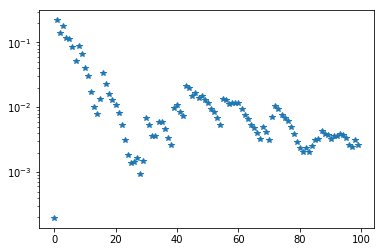

In [25]:
plt.semilogy(p_clusters[:,100], '*')

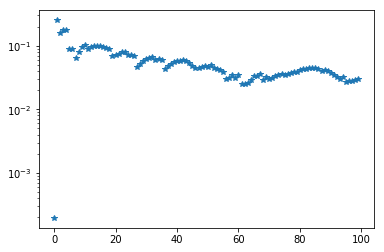

In [26]:
plt.semilogy(p_clusters[:,200], '*')

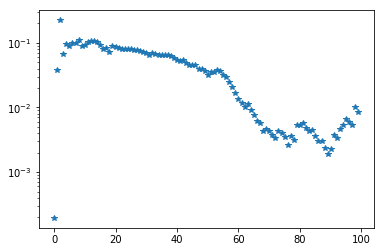

In [27]:
plt.semilogy(p_clusters[:,300], '*')

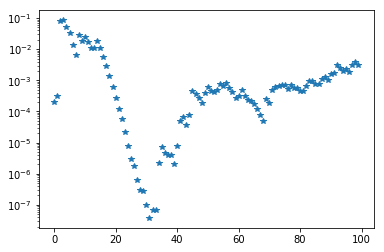

In [28]:
plt.semilogy(p_clusters[:,400], '*')

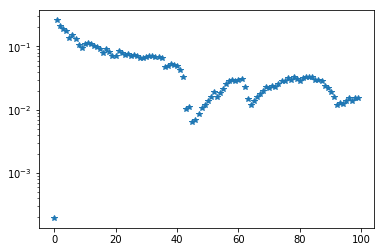

In [29]:
plt.semilogy(p_clusters[:,500], '*')